University of Padua
Digital forensics course, a.a. 2021/2022\
Alberto Grimaldi, _student ID:_ 2026705 ,  _email:_ alberto.grimaldi.1@studenti.unipd.it\
Cinthya Celina Tamayo Gonzalez, _student ID: 2041264 , email:_ cinthyacelina.tamayogonzalez@studenti.unipd.it

#Network anomaly detection
The objective of this project is to build an anomaly detection system based on **autoencoder** trained on clean data assumption.\
The UGR′16 dataset (available [here](https://www.frontiersin.org/articles/10.3389/frsip.2021.814129/full)) has been selecte. It contains traffic data recorded over 100 days, which identify four types of anomalous conditions, that is, types of attack: Clean, Dos11, Dos53, Scan11, Scan14.\
Traffic data are presented in 2D image representation in which the attack presence is highlighted. Exchanged bytes have been considered as traffic parameters and source and destination IPs have been used for indexing rows and columns of the images.





#Setup

In [ ]:
#Import libraries for plotting
import matplotlib
import matplotlib as mpl
from matplotlib import image
import matplotlib.pyplot as plt
import seaborn as sns

#Import standard libraries
import sklearn
import pickle
import random
import cv2
import PIL

from google.colab import drive
from os.path import exists
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score

import os
import numpy as np
import pandas as pd

#Import libraries for the model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

from keras.layers import Input , Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras.models import Model 
from keras import regularizers

#Setting some useful parameters for plotting
mpl.rcParams['figure.figsize'] = (10, 5)
mpl.rcParams['axes.grid'] = False

#Setting some constants
ENCODING_DIM = 512
TRAIN_DIM = 20000

Connect to our persnal drive where the dataset is sotred

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Let's unzip the dataset folder containing the traffic data in the form of matrices 256x256 .

In [ ]:
if not exists("dataset"):
  os.system("unzip -q /content/gdrive/MyDrive/df/dataset.zip -d dataset")

Do the same for train and test folders

In [ ]:
if not exists("train"):
  os.system("mkdir train")
if not exists("test"):
  os.system("mkdir test")

#Data exploration

Extract now the train.npz file which contains the train set in a compacted way 

In [ ]:
# laod the npz
train_npz = np.load('/content/gdrive/MyDrive/df/train.npz')

# extract the npy in train directory
if not exists("train/arr_0.npy"):
  train_npz.zip.extract('arr_0.npy', 'train')

In [ ]:
#load the content of npy into the data_train variable
data_train = np.load('train/arr_0.npy', mmap_mode='r+')

In [ ]:
#load the train dataset labels
csv_train = pd.read_csv('/content/gdrive/MyDrive/df/train.csv')

#plot the dataset
display(csv_train)
data_train_samples = csv_train['name']
data_train_labels = csv_train['type']

,name,type,fine_labels,coarse_labels
0,clean_1_august_V1_0,clean,0,0
1,clean_1_august_V1_1,clean,0,0
2,clean_1_august_V1_10,clean,0,0
3,clean_1_august_V1_100,clean,0,0
4,clean_1_august_V1_1000,clean,0,0
...,...,...,...,...
435399,clean_6_may_V4_995,clean,0,0
435400,clean_6_may_V4_996,clean,0,0
435401,clean_6_may_V4_997,clean,0,0
435402,clean_6_may_V4_998,clean,0,0


For efficiency reasons we have decided to reduce the amount of data to a fixed constant of 20000 samples.

In [ ]:
X_train=[]

# new train labels matrix
y_train=np.ones(TRAIN_DIM)

for i in range(TRAIN_DIM):
    index = random.randint(0, len(data_train))
    X_train.append(data_train[index])
X_train = np.array(X_train)
X_train.shape

(20000, 65536)

In [ ]:
#We set the new labels
labels = {
    'clean': 1,
    'dos11': 0,
    'dos53': 2,
    'scan11': 3,
    'scan44': 4
}

In [ ]:
# laod the npz
test_npz = np.load('/content/gdrive/MyDrive/df/test.npz')

# extract the npy in test directory
if not exists("test/arr_0.npy"):
  test_npz.zip.extract('arr_0.npy', 'test')

In [ ]:
new_data = np.load('test/arr_0.npy', mmap_mode='r+')

In [ ]:
#load the test dataset labels
csv_test = pd.read_csv('/content/gdrive/MyDrive/df/test.csv')

#plot the dataset
display(csv_test)

#these variable will be useful later for plotting images
data_test_samples = csv_test['name']
data_test_labels = csv_test['type']

data_test_samples_dos11 = csv_test[(csv_test['type']=='dos11')]['name'] 
data_test_samples_dos53 = csv_test[(csv_test['type']=='dos53')]['name']
data_test_samples_scan11 = csv_test[(csv_test['type']=='scan11')]['name']
data_test_samples_scan44 = csv_test[(csv_test['type']=='scan44')]['name']

data_test_labels_dos11 = csv_test[(csv_test['type']=='dos11')]['type']
data_test_labels_dos53 = csv_test[(csv_test['type']=='dos53')]['type']
data_test_labels_scan11 = csv_test[(csv_test['type']=='scan11')]['type']
data_test_labels_scan44 = csv_test[(csv_test['type']=='scan44')]['type']

#display the rows corresponding to the different types of anomalies
#we consider only the first index row for each anomaly because we need it later for the plotting
display(data_test_labels_dos11)
display(data_test_labels_dos53)
display(data_test_labels_scan11)
display(data_test_labels_scan44)

,name,type,fine_labels,coarse_labels
0,clean_1_august_V1_120,clean,0,0
1,clean_1_august_V1_1243,clean,0,0
2,clean_1_august_V1_1340,clean,0,0
3,clean_1_august_V1_1364,clean,0,0
4,clean_1_august_V1_1372,clean,0,0
...,...,...,...,...
15050,var_scan44_V2_non_ideal_74.npz,scan44,4,2
15051,var_scan44_V2_non_ideal_75.npz,scan44,4,2
15052,var_scan44_V2_non_ideal_76.npz,scan44,4,2
15053,var_scan44_V2_non_ideal_8.npz,scan44,4,2


4596    dos11
4597    dos11
4598    dos11
4599    dos11
4600    dos11
        ...  
6266    dos11
6267    dos11
6268    dos11
6269    dos11
6270    dos11
Name: type, Length: 1675, dtype: object

6271     dos53
6272     dos53
6273     dos53
6274     dos53
6275     dos53
         ...  
10862    dos53
10863    dos53
10864    dos53
10865    dos53
10866    dos53
Name: type, Length: 4596, dtype: object

10867    scan11
10868    scan11
10869    scan11
10870    scan11
10871    scan11
          ...  
11854    scan11
11855    scan11
11856    scan11
11857    scan11
11858    scan11
Name: type, Length: 992, dtype: object

11859    scan44
11860    scan44
11861    scan44
11862    scan44
11863    scan44
          ...  
15050    scan44
15051    scan44
15052    scan44
15053    scan44
15054    scan44
Name: type, Length: 3196, dtype: object

Let's have an overview of the anomaly distribution in our test set

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


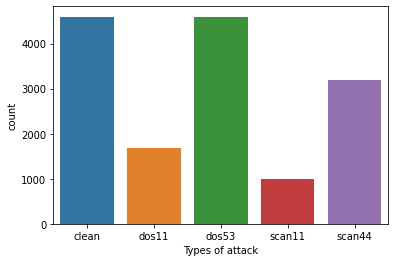

In [ ]:
# Plotting the types of anomaly based on their label
sns.countplot(csv_test.type)
plt.xlabel('Types of attack');

Here the definition of the identified attacks\
• **Denial of Service (DoS)**:

  - DoS11: one-to-one DoS where attacker A1 attacks the victim V21;

  - DoS53: the five attackers (A1 − A5) attack three victims. More   specifically, attackers A1 and A2 attack the victim V21, attackers A3 and A4 attack the victim V31, and attacker A5 attacks the victim V41;

• **Port Scanning**:

  - Scan11: one-to-one scan attack where attacker A1 scans the victim V41;

  - Scan44: four-to-four scan attack where the attackers A1, A2, A3 and A4 scan the victims V21, V11, V31 and V41, respectively.

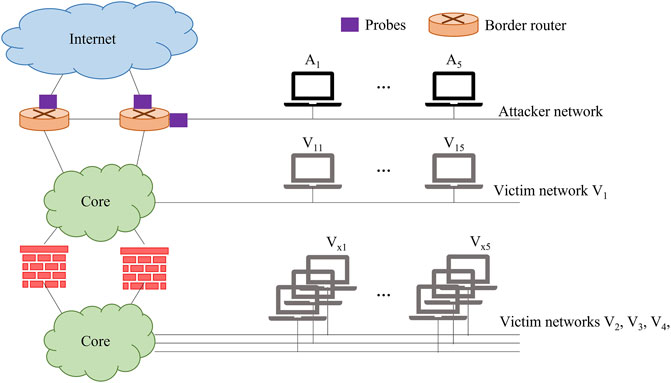

Now we plot an image for each of the attack typologies

Text(0.5, 1.0, 'Scan44')

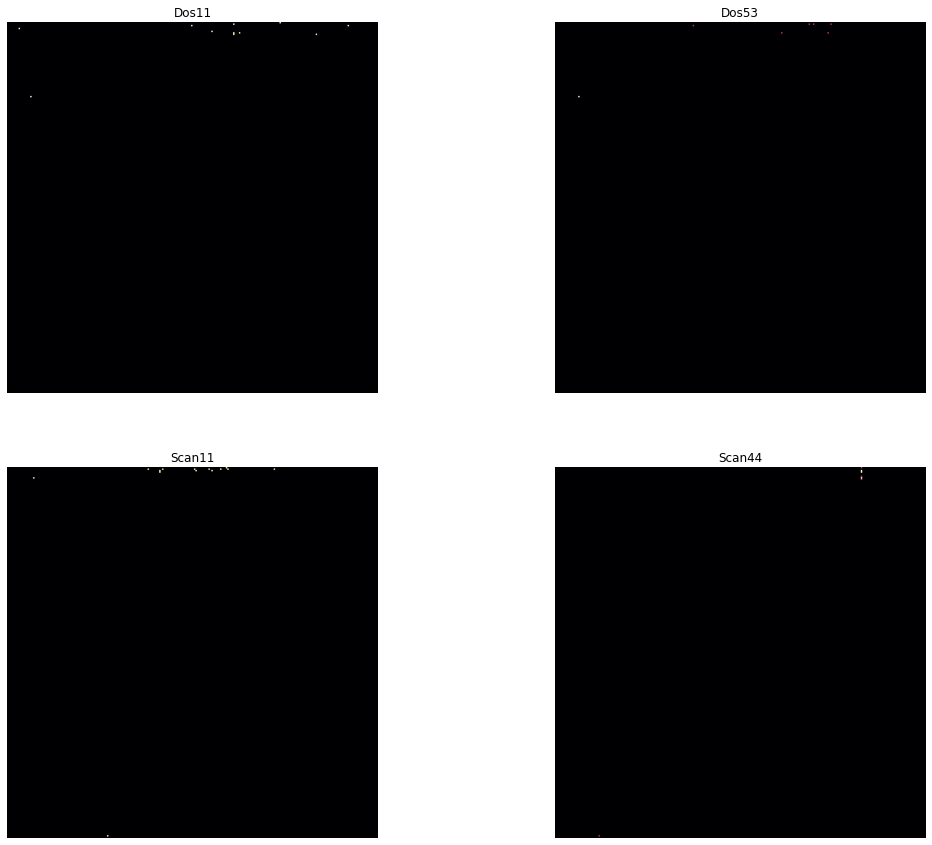

In [ ]:
# create figure
fig = plt.figure(figsize=(18, 15))
  
# setting values to rows and column variables
rows = 2
columns = 2
  
# reading images
# we selected the first index row per each type of attack
Image1 = image.imread("dataset/test/"+data_test_labels_dos11[4596]+"/"+data_test_samples_dos11[4596]+".png")
Image2 = image.imread("dataset/test/"+data_test_labels_dos53[6271]+"/"+data_test_samples_dos53[6271]+".png")
Image3 = image.imread("dataset/test/"+data_test_labels_scan11[10867]+"/"+data_test_samples_scan11[10867]+".png")
Image4 = image.imread("dataset/test/"+data_test_labels_scan44[11859]+"/"+data_test_samples_scan44[11859]+".png")
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("Dos11")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Dos53")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Scan11")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(Image4)
plt.axis('off')
plt.title("Scan44")

In [ ]:
# we store the labels of test set in the array y
y = []
for i in range(len(new_data)):
  y.append(labels[data_test_labels[i]])
y = np.array(y)

#split the dataset into validation and test set
X_test, X_val, y_test, y_val = train_test_split(new_data, y, train_size=TRAIN_DIM//10, test_size = TRAIN_DIM//20, random_state = np.random.RandomState(42), shuffle=True)

In [ ]:
for i in range(len(labels.keys())):
  print("Label: "+str(i)+", Amount: "+ str(np.count_nonzero(y_test == i)))

Label: 0, Amount: 244
Label: 1, Amount: 614
Label: 2, Amount: 620
Label: 3, Amount: 132
Label: 4, Amount: 390


In [ ]:
for i in range(len(labels.keys())):
  print("Label: "+str(i)+", Amount: "+ str(np.count_nonzero(y_val == i)))

Label: 0, Amount: 116
Label: 1, Amount: 331
Label: 2, Amount: 283
Label: 3, Amount: 70
Label: 4, Amount: 200


# The model: *Autoencoder*


An autoencoder is a type of artificial neural network used to learn efficient codings of unlabeled data (unsupervised learning). The encoding is validated and refined by attempting to regenerate the input from the encoding. The autoencoder learns a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore insignificant data (“noise”) (source: [wikipedia](https://en.wikipedia.org/wiki/Autoencoder)).

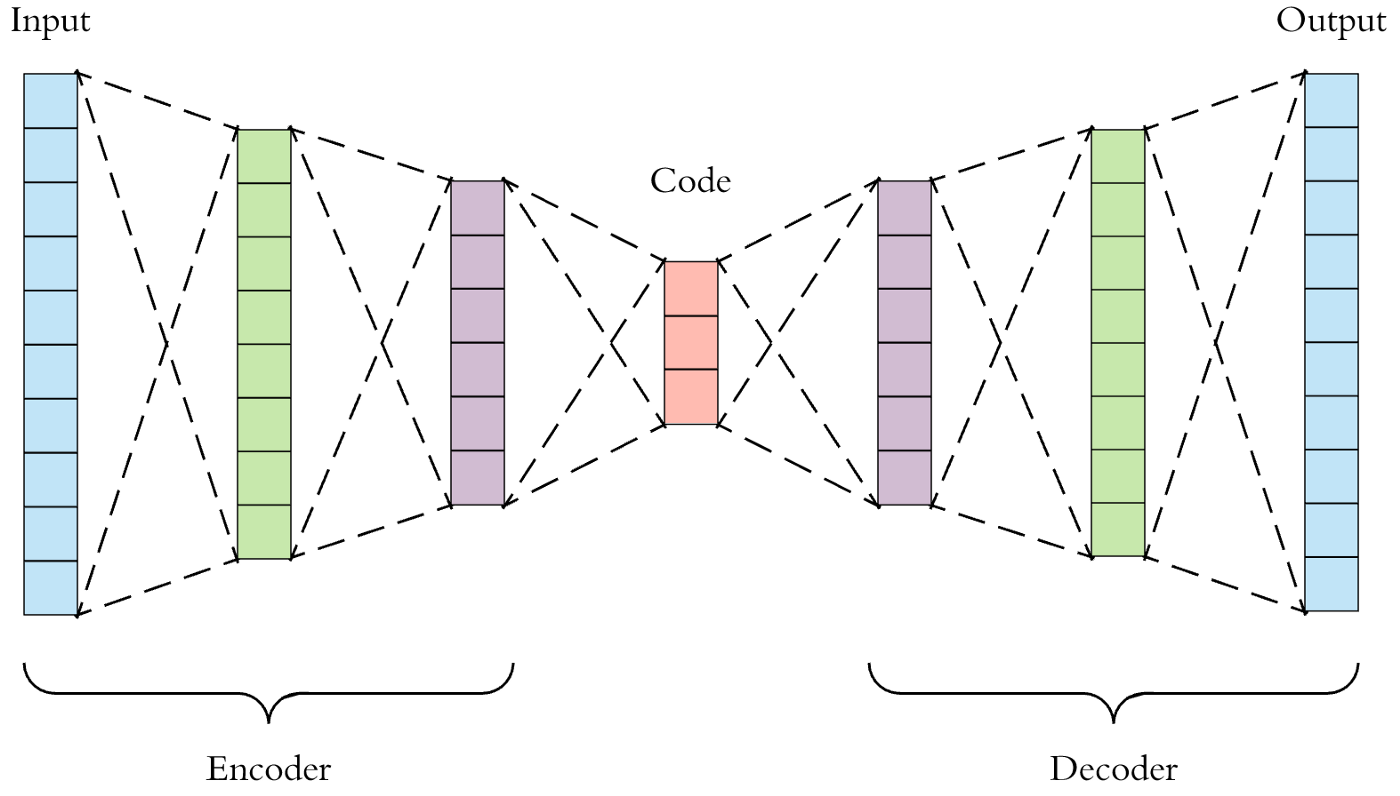

The main application of an autoencoder is the detection of anomalies or the reduction of noise (denoising) of images.\
Another way to use is the image compression, indeed if we have a intermediate dimensinality *d* smaller than the input *n*, then the encoder can be used to compress input data such that the hidden representation should represent the whole input information in a lower space.



What we are looking for is to detect the anomaly data through the reconstruction error. We are going to obtain the error in normal data (clean data in training) and then test the model on anomaly data, the reconstruction error must be higher then. Moreover, after this we can classificate by clustering with the hidden representations that we get from the encoder.


We opted for an autoencoder composed by *six* layers in total: *three* for the encoder and *three* for the decoder. The activation function are Sigmoid and Relu with Softmax in the ouput layer . This combination gives us a sufficient result for the task to be performed. More details about the design process and comments in the conclusions. 

In [ ]:
#built our model

class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(ENCODING_DIM, activation="sigmoid"),
      layers.Dense(ENCODING_DIM/2, activation="relu"),
      layers.Dense(128, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(ENCODING_DIM/2, activation="relu"),
      layers.Dense(ENCODING_DIM, activation="relu"),
      layers.Dense(256*256, activation="softmax")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

Once the model is created, we can now config the model with losses and metrics with *model.compile()*, train the model with *model.fit()*, and use the model to do prediction with *model.predict()*.

In [ ]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='msle')

In [ ]:
#we define a callbacks to early stopping the training when the error stops decreasing after a certain number of epochs
callbacks = tf.keras.callbacks.EarlyStopping(patience=2)

history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=30, shuffle=True, callbacks=callbacks, validation_data=(X_val, X_val))
#!mkdir -p saved_model
#history.save('saved_model/my_model')

Epoch 1/10
667/667 [==============================] - 17s 20ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 2/10
667/667 [==============================] - 13s 20ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 3/10
667/667 [==============================] - 13s 20ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 4/10
667/667 [==============================] - 13s 20ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 5/10
667/667 [==============================] - 13s 20ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 6/10
667/667 [==============================] - 13s 20ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 7/10
667/667 [==============================] - 13s 19ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 8/10
667/667 [==============================] - 13s 19ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 9/10
667/667 [==============================] - 13s 19ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 10/10
667/667 [==============================] - 13s 20ms/step - loss: 0.002

Let's plot now the train and validation loss

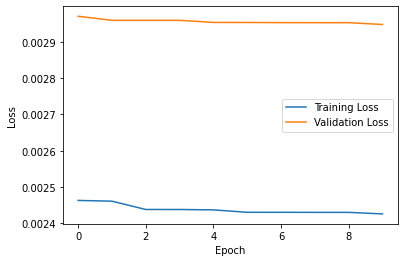

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [ ]:
test_scores = autoencoder.evaluate(X_test, X_test, verbose=2)
print("test msle: %.5f" % (test_scores))

63/63 - 0s - loss: 0.0031 - 308ms/epoch - 5ms/step
test msle: 0.00305


#Anomaly detection

We compute a prediction for the training samples. We considered only the first 2000 samples because the computational effort get too high for the free version of Google Colab.

In [ ]:
reconstruction = autoencoder.predict(X_train[:2000])

Using the same error as in we used in the training phase MSLE:

In [ ]:
msle = tf.keras.losses.MeanSquaredLogarithmicError()


First the nominal error:

In [ ]:
train_loss =msle(X_train[:2000], reconstruction).numpy()
print(train_loss)

0.0023627125


The threshold as a function of the training error: 

In [ ]:
#compute the threshold
threshold = np.mean(train_loss) + 2*np.std(train_loss)
print(threshold)

0.0023627125192433596


Now the anomaly data: 

In [ ]:
reconstruction_anoma = autoencoder.predict(X_test)

In [ ]:
t_loss_a = msle(X_test,reconstruction_anoma).numpy()
print(t_loss_a)

0.0030461221


Now in a plot: 

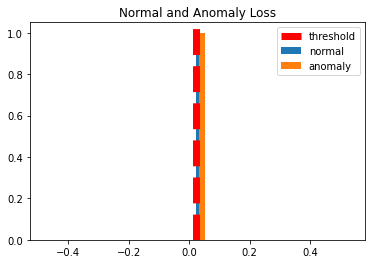

In [ ]:
plt.hist(train_loss*10, bins=50, label='normal')
plt.hist(t_loss_a*10, bins=50, label='anomaly')
plt.axvline(threshold*10, color='r', linewidth=7, linestyle='dashed', label= 'threshold')
plt.legend(loc='upper right')
plt.title("Normal and Anomaly Loss")
plt.show()

As the difference can not be noticed easily with the mean sqauare log error, then let us try the mean square  error.

We change the loss function to have a more significative threshold

In [ ]:
mse = tf.keras.losses.MeanSquaredError()
 

In [ ]:
#we obtain the training loss
train_loss =mse(X_train[:2000], reconstruction).numpy()
print(train_loss)

3.450309


In [ ]:
#compute the threshold
threshold = np.mean(train_loss) + 2*np.std(train_loss)
print(threshold)

3.4503090381622314


We compute prediction for test set

In [ ]:
reconstruction_anoma = autoencoder.predict(X_test)

In [ ]:
#we obtain the trining loss

t_loss_a = mse(X_test,reconstruction_anoma).numpy()
print(t_loss_a)

4.742331


Plot the average loss for training (clean) data and test data which contain anomalies

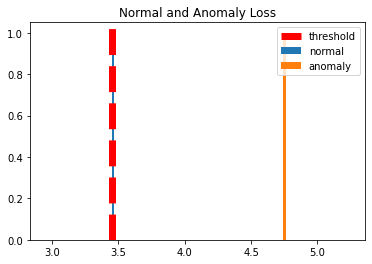

In [ ]:
plt.hist(train_loss, bins=50, label='normal')
plt.hist(t_loss_a, bins=50, label='anomaly')
plt.axvline(threshold, color='r', linewidth=7, linestyle='dashed', label= 'threshold')
plt.legend(loc='upper right')
plt.title("Normal and Anomaly Loss")
plt.show()

In this way is longer the gap between them, then the detection is easier. Notice that is the same autoencoder, therefore the same hidden representations we are goin to use in the next step. 


#Clustering

We decided to classify the type of attack by means of clustering techniques.
Moreover, we explore different clustering techniques to compare them and see how the different algorithms work in grouping and identifyng the types of traffic data.\
For our goal we are considering a new dataset made by the combination of the test set and validation set.

In [ ]:
#concatenate test and validation set
lista = np.concatenate([X_test, X_val])
y = np.concatenate([y_test, y_val])

In particolar we use the hidden representation of the autoencoder which allow us to keep the most characterizing features of input data

In [ ]:
#retrieve the hidden data representation
out_encoded = autoencoder.encoder(lista) #128 unit representation of data
print(out_encoded)

tf.Tensor(
[[ 0.908747    0.          0.89469516 ...  0.5200391   0.
   0.        ]
 [ 0.          0.          0.         ...  2.6524587  10.08241
   0.        ]
 [ 0.6140625   0.          0.48462734 ...  0.13488404  0.
   0.        ]
 ...
 [ 0.36309025  0.          0.5855197  ...  0.31571624  0.
   0.        ]
 [ 0.34995365  0.          0.61797434 ...  0.57549703  0.
   0.        ]
 [ 0.          6.3362575   2.3680983  ...  0.          0.
  26.255392  ]], shape=(3000, 128), dtype=float32)


PCA is dimensionality reduction algorithm that project each data point onto only the first few principal components to obtain lower-dimensional data while preserving as much of the data's variation as possible. [8]

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
T_L=pca.fit_transform(out_encoded)


First we try with Agglomerative clustering . It's a type of hierarchical clustering algorithm with a bottom-up approach. Start with many small clusters and merge them together to create bigger clusters.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit_predict(out_encoded)

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
#define this function for plotting clusters
def plot_cl(data, labels):
     plt.figure(figsize=(10, 10))
     palette = sns.color_palette('hls', n_colors=len(set(labels)))
     sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=labels, palette=palette, legend='full')
     plt.axis('off')
     plt.show()

More over we will use the silhouette Coefficient or silhouette score, that is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1. [10]

1: Means clusters are well apart from each other and clearly distinguished.

0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.

-1: Means clusters are assigned in the wrong way.

First we considered only two classes to distinguish clean data from anomalies.

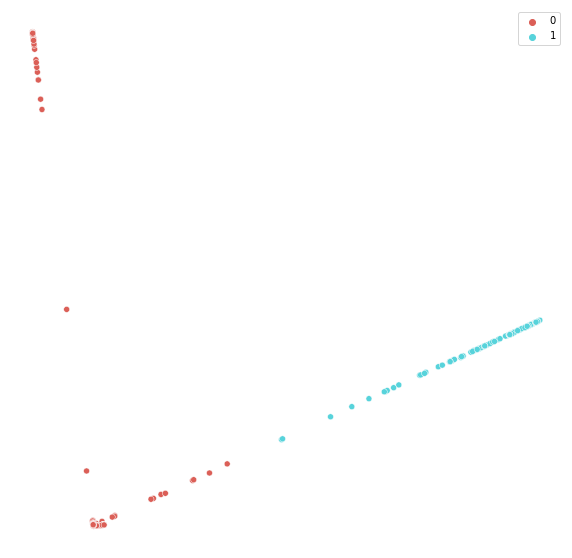

In [ ]:
plot_cl(T_L, cluster.labels_)

In [ ]:
silhouettescore = sklearn.metrics.silhouette_score(out_encoded, cluster.labels_)
print(silhouettescore)

0.8559235


Now we consider the five classes

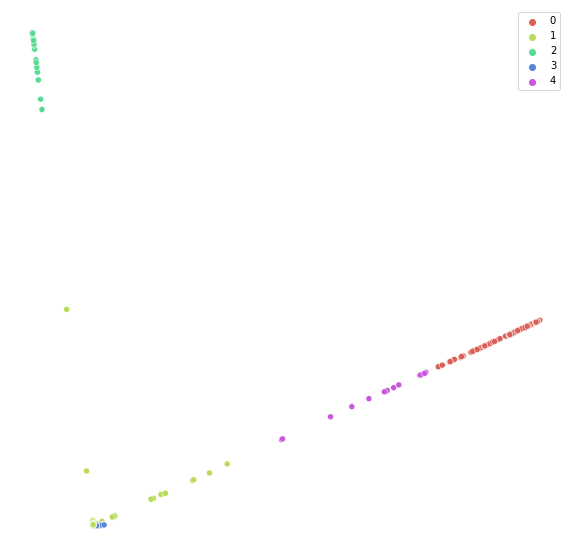

In [ ]:
cluster_all = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
cluster_all.fit_predict(out_encoded)
plot_cl(T_L, cluster_all.labels_)

In [ ]:
silhouettescore = sklearn.metrics.silhouette_score(out_encoded, cluster_all.labels_)
print(silhouettescore)

0.9031446


Let use another dimensionality reduction techinique.

Isomap is a nonlinear dimensionality reduction method 

In [ ]:
from sklearn.manifold import Isomap 
isomap = Isomap(n_components=2, n_jobs = 4, n_neighbors = 5)

T_G=isomap.fit_transform(out_encoded)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/s

Again, we plot only two classes first

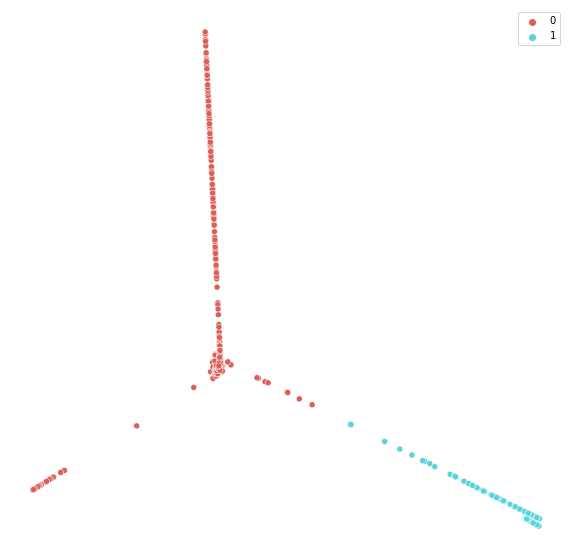

In [ ]:
cluster_all_2= AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster_all_2.fit_predict(out_encoded)
plot_cl(T_G, cluster_all_2.labels_)

In [ ]:
silhouettescore = sklearn.metrics.silhouette_score(out_encoded, cluster_all_2.labels_)
print(silhouettescore)

0.8559235


Now plot all 5 classes

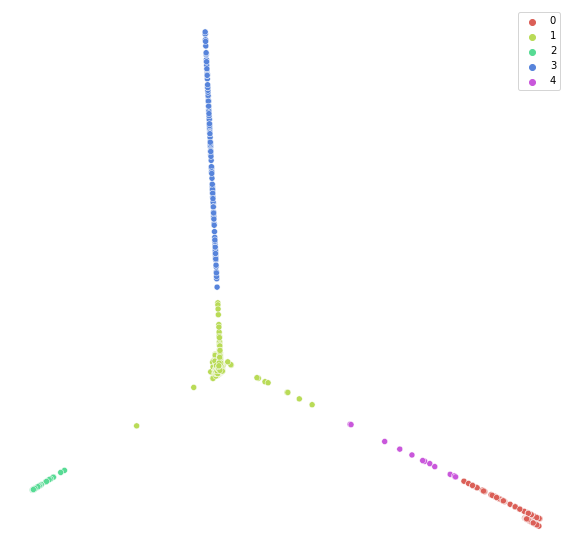

In [ ]:
cluster_all_2= AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
cluster_all_2.fit_predict(out_encoded)
plot_cl(T_G, cluster_all_2.labels_)

In [ ]:
silhouettescore = sklearn.metrics.silhouette_score(out_encoded, cluster_all_2.labels_)
print(silhouettescore)

0.9031446


Trying another way of mapping and clustering, now we use K-means and TSNE. 

In [ ]:
tsne = TSNE(n_components = 2, metric = "euclidean",random_state = np.random.RandomState(54))
T_T=tsne.fit_transform(out_encoded)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


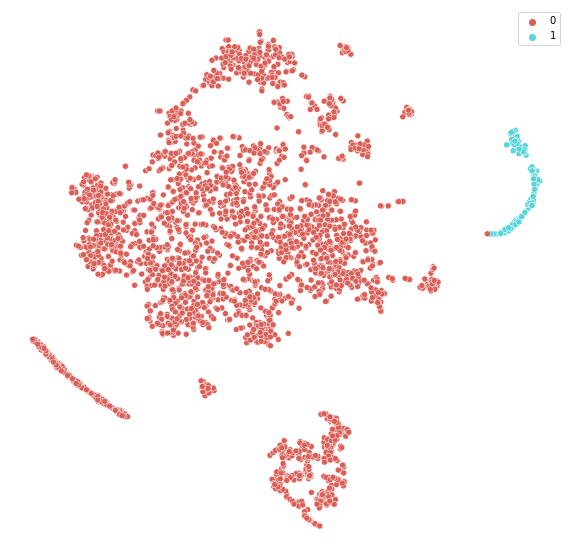

In [ ]:
cluster_all_f= KMeans(n_clusters = 2, random_state = np.random.RandomState(78), init='k-means++')
cluster_all_f.fit_predict(out_encoded)
plot_cl(T_T, cluster_all_f.labels_)

In [ ]:
silhouettescore = sklearn.metrics.silhouette_score(out_encoded, cluster_all_f.labels_)
print(silhouettescore)

0.85686904


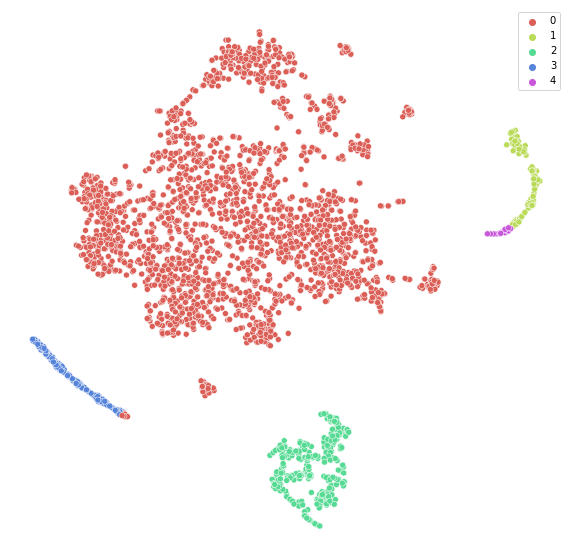

In [ ]:
cluster_all_f= KMeans(n_clusters = 5, random_state = np.random.RandomState(78), init='k-means++')
cluster_all_f.fit_predict(out_encoded)
plot_cl(T_T, cluster_all_f.labels_)

In [ ]:
silhouettescore = sklearn.metrics.silhouette_score(out_encoded, cluster_all_f.labels_)
print(silhouettescore)

0.90360093


#Conclusions

Through this project we could see the relevance of having an adequate autoencoder because the whole performance relays on the results of the autoencoder, for instance: Depending in the reconstruction and error of the autoencoder we can detect when there was anomaly data; furthermore the performance also affects how big is the gap between the anomaly data and the nominal data.
 
On the other hand, the hidden representations were used in order to detect the types of anomalies by clustering them. We could observe the relevance of the internal representations, because if we had a model compressing a lot of data through many layers, then the clustering with 2 layers could perform good but with all the types of anomalies the performance is very poor. Basically because the compression was deleting some information that was relevant for identifying all the anomalies.
In a similar way, if the latent representations + the reduction method at the end are the key of the final clustering. For instance we tried several models, with many types of activation functions and reductions, let us comment with more detail:
 
**Autoencoder**\
During the modeling we tried several activation functions such as ReLu, Softmax, sigmoid, Swish, tanh, Elu and the designing process was a join between theory and empirical results training to reach the best.
 
The final model in the autoencoder for the internal representation was Sigmoid, ReLu, ReLu, ReLu, ReLu, Softmax. We reach this structure because sigmoid squishes the results between 0-1 therefore, helps us to catch mean and reduced representations, then we selected ReLu for the following layers because sigmoid in the internal layers several times can produce saturation in the model[7].  Finally we selected for the final layer a more complex function than ReLu and with a longer range of output than sigmoid, softmax.
 
 
**Clustering**
 
 
We tested two types of clustering algorithms: K-means and agglomerative clustering; because we wanted two observe the results with one method which randomly picks the centers of the clusters and another one that is a hierarchical method. The most interesting thing we noticed is that both of them are capable of detecting anomalies in general, that is, in the case where we discriminate only two classes (clean from anomaly), giving good results. The performances some times decrease a bit when we want to classify five classes, however we can see on the results are still good enough.\
 
Moreover, as was mentioned in the beginning of this section, also the reduction method plays a very important role. For instance, we can see in the results how we have isomap dimensionality reduction with agglomerative clustering and the performance is a little bit better with 5 classes than a binary classification and this is probably because of the proximity that has one of the anomalie's representation with the one from nominal data, than we detects it as an individual anomalie can distinguish better from normal data.
 
**Further comments**
 
The methods for dimensionality reduction are not the mean part of the project, however they have influence on the final results and therefore worthy of mention. How the functions map the elements to 2D space is basically the base for the next step that is the clustering. As it is shown in the first two results, we have agglomerative clustering for both of them with the methods: PCA and Isomap. PCA is a method that makes a decomposition in order to extract the mean features, it is a simple method and it is shown how the final map is very simple in comparison with the following methods. On the other hand, we have Isomap that uses a multidimensional scaling to compute lower-dimensional embedding, consequently the representation of isomap is more complex than PCA, that helps to get good results with the multiclass clustering. For the binary classification, it is clear how in PCA's result the elements are well splitted.
In any case, the last and best result was with TSNE, which is good at preserving small pairwise distances, giving as a result good clusters in both escenarios( 2 and 5 classes). \
As a last comment we could add that working with a high amount of data with the free version of Colab was challenging and in some cases we had to make some reductions of data. We tried to use more powerful models as LSTM autoencoder but again with the limitations it was difficult to train and optimize, so we decided to keep a normal autoencoder and improve it as much as possible to get the best results.


**References**


[1]*Complete Guide to Anomaly Detection with AutoEncoders using Tensorflow*, Raghav Agrawal, Analytics Vidhya, January 3, 2022. https://www.analyticsvidhya.com/blog/2022/01/complete-guide-to-anomaly-detection-with-autoencoders-using-tensorflow/


[2]*Dimensionality Reduction toolbox in python*, Mohamed Chérif Haidara, Towards Data Science, Mar 11, 2019. https://towardsdatascience.com/dimensionality-reduction-toolbox-in-python-9a18995927cd.

[3]*Deep Learning*, Ian Goodfellow and Yoshua Bengio and Aaron Courville, MIT Press, 2016. Page 269, Chapter 7.  
Online version: https://www.deeplearningbook.org/ 


[4]*Hierarchical Clustering with Python and Scikit-Learn*, Usman Malik, Stackabuse, April 26th, 2022. https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/

[5]*How to Display Multiple Images in One Figure Correctly in Matplotlib?*, Patild Hanu,  02 Feb 2021.
https://www.geeksforgeeks.org/how-to-display-multiple-images-in-one-figure-correctly-in-matplotlib/


[6]*Intro to Autoencoders*, TensorFlow.
https://www.tensorflow.org/tutorials/generative/autoencoder


[7]*Isomap Embedding — An Awesome Approach to Non-linear Dimensionality Reduction*, Saul Dobilas, 
Towards Data Science, Aug 21, 2021. https://towardsdatascience.com/isomap-embedding-an-awesome-approach-to-non-linear-dimensionality-reduction-fc7efbca47a0 


[8]*PCA using Python (scikit-learn)*, Michael Galarnyk, Towards Data Science, Dec. 4, 2017. https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60 


[9]*Regression losses*, Keras. https://keras.io/api/losses/regression_losses/#mean_squared_logarithmic_error-function


[10]*Silhouette Coefficient*, Ashutosh Bhardwaj, Towards Data Science,May 26, 2020. https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c

